In [1]:
from naslib.utils.io import read_json
from pathlib import Path 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.axes import Axes

In [178]:
sns.set_style("white")
rcParams['axes.titlepad'] = 15
rcParams['font.size'] = 9

In [112]:
QUERY_VAL_ACC = "valid_acc"
QUERY_CAL_ERR = "calibration_score" 
LOG_FILENAME = "errors.json"

def collect_info_all_seeds(folder: Path, filename: str = LOG_FILENAME, query_key: str = QUERY_CAL_ERR):
    matches = list(folder.rglob(pattern=f"./seed=*"))

    scores={}
    for p in matches:
        scores[p.name] = read_json(p / filename)[query_key]
    df = pd.DataFrame(scores)
    df.index += 1   # python indexing starts from 0
    df.index.name = "epochs"
    return df.sort_index(axis=1)

In [130]:
def plot_single_experiment(path: Path, ax: Axes, label: str | None, query_key: str, ylabel: str, start_epoch=0, dahses = None):
    df_wide = collect_info_all_seeds(folder=path, query_key=query_key)     
    mean = df_wide.iloc[-1, :].mean()
    std = df_wide.iloc[-1, :].std()

    df_wide = df_wide.reset_index()    
    df_wide = df_wide[df_wide["epochs"] >= start_epoch]
    df_long = pd.melt(df_wide, id_vars='epochs')
    legend = None if label is None else "auto"

    label = f"{label}: mean={round(mean, 3)}, std={round(std, 4)}"
    sns.lineplot(x="epochs", data=df_long, y="value", err_style="band", errorbar="sd", label=label, ax=ax, legend=legend, alpha=0.8, dashes=dahses)
    ax.set_xlabel("epochs")
    ax.set_ylabel(ylabel=ylabel)
    ax.tick_params(labelbottom=True)
    return ax

In [ ]:
datasets = ["CIFAR10" , "CIFAR100", "ImageNet16-120"]
home = Path.home() / "Desktop/Experiments"

def get_label_and_path(dataset): 
    if "CIFAR" in dataset:
        dataset = dataset.lower()
 #   exp_0 = home/"acq_search=mutation/nasbench201" / dataset / "acq=its/num_to_mutate=2/num_init=10/bananas__ensemble_mlp__gaussian__num_quantiles=10"
    exp_1 = home/"acq_search=mutation/nasbench201" / dataset  / "acq=its/num_to_mutate=2/num_init=10/bananas__ensemble_mlp__CP_split__train_cal_split=05__num_quantiles=10"
    exp_2 = home/"acq_search=dynamic/nasbench201" / dataset  / "acq=its/num_to_mutate=None/num_init=10/bananas__ensemble_mlp__CP_split__train_cal_split=05__num_quantiles=10"
    exp_3 = home/"acq_search=random_sampling/nasbench201" / dataset  / "acq=its/num_to_mutate=None/num_init=10/bananas__ensemble_mlp__CP_split__train_cal_split=05__num_quantiles=10"

    label_and_path = {
    #    "uncalibrated": exp_0,
        "scp (mutation)": exp_1,
        "scp (dynamic)": exp_2,
        "scp (random sampling)": exp_3,
    #    "scp (acq=EI)": exp_3,
    #    "scp (acq=PI)": exp_4,
    }
    return label_and_path

### Visualise validation accuracy and RMSCE per epoch

In [193]:
color_set = [
    "#377EB8",  # blue
    "#4DAF4A",  # green
    "#FF7F00",  # orange
    "#984EA3",  # purple
    "#E41A1C",  # red
  #  "#FFD92F",  # yellow
 #   "#00CED1",  # cyan/turquois
]

# Set as default cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_set)

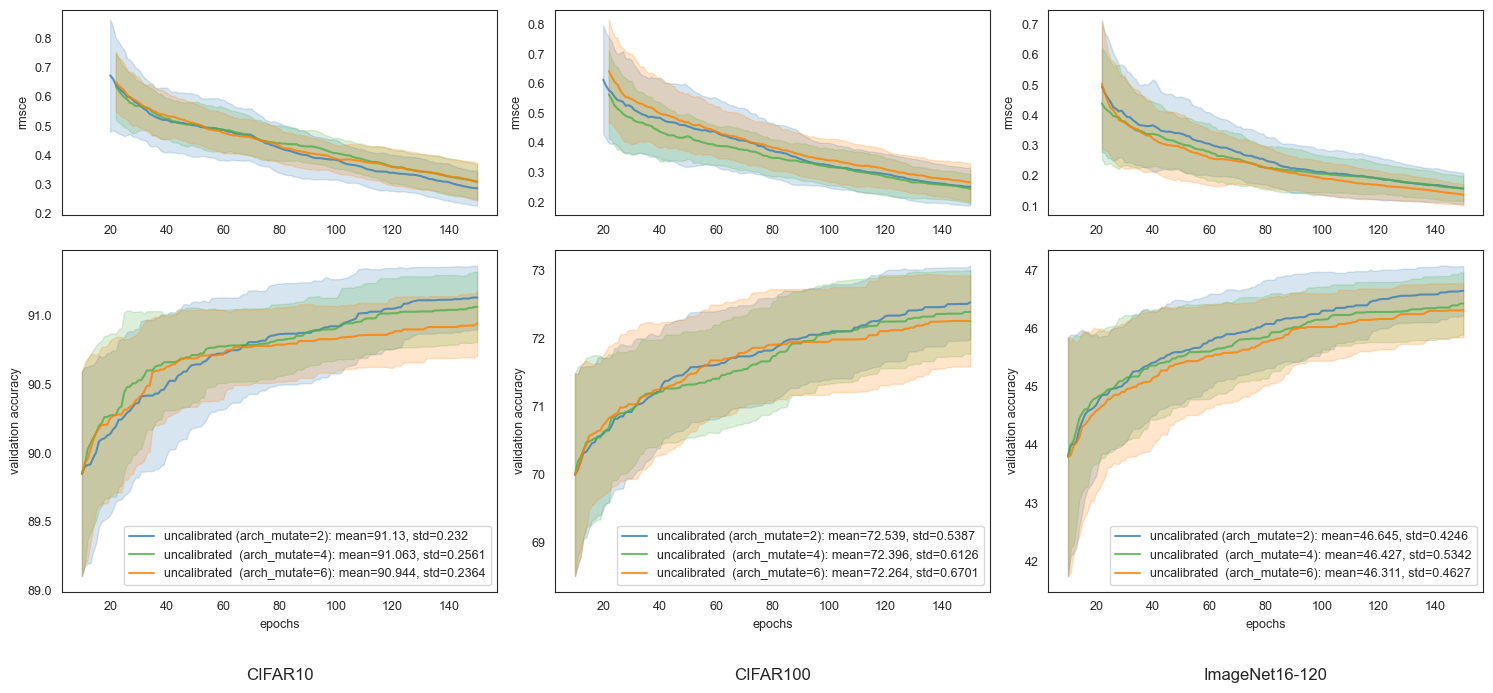

In [194]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 7),sharex=True, gridspec_kw={"height_ratios" : [1.5, 2.5]})
start_epoch = 10


for i, dataset in enumerate(datasets):
    label_and_path = get_label_and_path(dataset=dataset)
    for j,  (label, path) in enumerate(label_and_path.items()):
        plot_single_experiment(path=path, ax=axes[0, i], label=None, query_key=QUERY_CAL_ERR, ylabel="rmsce", start_epoch=start_epoch)
        plot_single_experiment(path=path, ax=axes[1, i], label=label, query_key=QUERY_VAL_ACC, ylabel="validation accuracy", start_epoch=start_epoch)
        axes[1, i].legend(loc="lower right")
        
        axes[1, i].set_title(dataset, y=0, pad=-55, verticalalignment="top", fontsize=12)
plt.tight_layout()

In [88]:
plt.show()

In [125]:
path = Path(home/"acq_search=mutation/nasbench201" / dataset / "acq=its/num_to_mutate=2/num_init=10/bananas__ensemble_mlp__CP_split__train_cal_split=05__num_quantiles=10")

scores_1 = collect_info_all_seeds(path, query_key=QUERY_VAL_ACC).iloc[-1, :]
print(scores_1.mean())
print(scores_1.std())

46.644666619669586
0.4246172020229582
